# WMT Backtesting Strategy

## Introduction

This notebook demonstrates a simple backtesting strategy for WMT (Walmart) stock using the Backtrader library. We'll progressively build up our script in three stages:

1. Basic strategy execution without plotting or detailed output
2. Strategy execution with a summary table
3. Full strategy execution with plotting and summary table

Let's begin with the imports and strategy definition that will be common to all threeversions:


In [1]:
import backtrader as bt
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tabulate import tabulate

class SimpleStrategy(bt.Strategy):
    params = (
        ('sma_period', 20),
    )

    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.sma_period)
        self.order = None
        self.trade_log = []
        self.portfolio_value = []

    def next(self):
        market_value = self.position.size * self.data.close[0] if self.position else 0
        self.portfolio_value.append(self.broker.getcash() + market_value)

        if self.order:
            return

        if not self.position:
            if self.data.close[0] > self.sma[0]:
                available_cash = self.broker.getcash()
                max_size = int(available_cash / self.data.close[0])
                self.order = self.buy(size=max_size)
        else:
            if self.data.close[0] < self.sma[0]:
                self.order = self.sell(size=self.position.size)

    def notify_order(self, order):
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log_trade("BUY", order.executed.size, order.executed.price)
            elif order.issell():
                self.log_trade("SELL", order.executed.size, order.executed.price)
        self.order = None

    def log_trade(self, order_type, size, price):
        self.trade_log.append({
            'date': self.data.datetime.date(0),
            'type': order_type,
            'price': price,
            'size': size,
            'portfolio_value': self.portfolio_value[-1],
            'position': self.position.size
        })

## Stage 1: Basic Strategy Execution

In this first stage, we'll run the strategy without any detailed output or plotting. We'll only print the final portfolio value.


In [2]:
# Load data
data = pd.read_csv('WMT.csv')
data.set_index(pd.to_datetime(data.iloc[:, 0]), inplace=True)
data.index.name = 'date'

# Create and run a Cerebro engine
cerebro = bt.Cerebro()
cerebro.adddata(bt.feeds.PandasData(dataname=data))
cerebro.addstrategy(SimpleStrategy)

# Set initial cash
initial_cash = 100000.0
cerebro.broker.setcash(initial_cash)

# Run the strategy
results = cerebro.run()
strategy = results[0]

# Print final portfolio value
final_value = strategy.portfolio_value[-1] if strategy.portfolio_value else initial_cash
print(f'Final Portfolio Value: {final_value:.2f} ADA')

Final Portfolio Value: 243527.64 ADA


## Stage 2: Strategy Execution with Summary Table

In this stage, we'll add a summary table that shows all the trades made during the backtesting period.

In [3]:
# Load data and run strategy (same as Stage 1)
data = pd.read_csv('WMT.csv')
data.set_index(pd.to_datetime(data.iloc[:, 0]), inplace=True)
data.index.name = 'date'
cerebro = bt.Cerebro()
cerebro.adddata(bt.feeds.PandasData(dataname=data))
cerebro.addstrategy(SimpleStrategy)
initial_cash = 100000.0
cerebro.broker.setcash(initial_cash)
results = cerebro.run()
strategy = results[0]

# Print trade summary table
print("\nTrade Summary Table:")
table_data = [
    [trade['date'], trade['type'], f"{trade['price']:.2f} ADA", trade['size'],
     f"{trade['portfolio_value']:.2f} ADA", trade['position']]
    for trade in strategy.trade_log
]
headers = ["Date", "Type", "Price", "Size", "Portfolio Value", "Position"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))

# Print performance summary
final_value = strategy.portfolio_value[-1] if strategy.portfolio_value else initial_cash
total_pnl = final_value - initial_cash
total_return = (final_value - initial_cash) / initial_cash

print(f'\nInitial Portfolio Value: {initial_cash:.2f} ADA')
print(f'Final Portfolio Value: {final_value:.2f} ADA')
print(f'Total Profit/Loss: {total_pnl:.2f} ADA')
print(f'Total Return: {total_return:.2%}')


Trade Summary Table:
+------------+--------+----------+---------+-------------------+------------+
| Date       | Type   | Price    |    Size | Portfolio Value   |   Position |
+============+========+==========+=========+===================+============+
| 2022-04-14 | BUY    | 0.60 ADA |  167813 | 100000.00 ADA     |     167813 |
+------------+--------+----------+---------+-------------------+------------+
| 2022-04-21 | SELL   | 0.58 ADA | -167813 | 97801.65 ADA      |          0 |
+------------+--------+----------+---------+-------------------+------------+
| 2022-05-28 | BUY    | 0.47 ADA |  207514 | 97801.65 ADA      |     207514 |
+------------+--------+----------+---------+-------------------+------------+
| 2022-06-14 | SELL   | 0.49 ADA | -207514 | 100852.11 ADA     |          0 |
+------------+--------+----------+---------+-------------------+------------+
| 2022-06-15 | BUY    | 0.50 ADA |  200541 | 100852.11 ADA     |     200541 |
+------------+--------+----------+--------

## Stage 3: Full Strategy Execution with Plotting

In this final stage, we'll add a visualization of the WMT price, the Simple Moving Average (SMA), and the portfolio value over time.


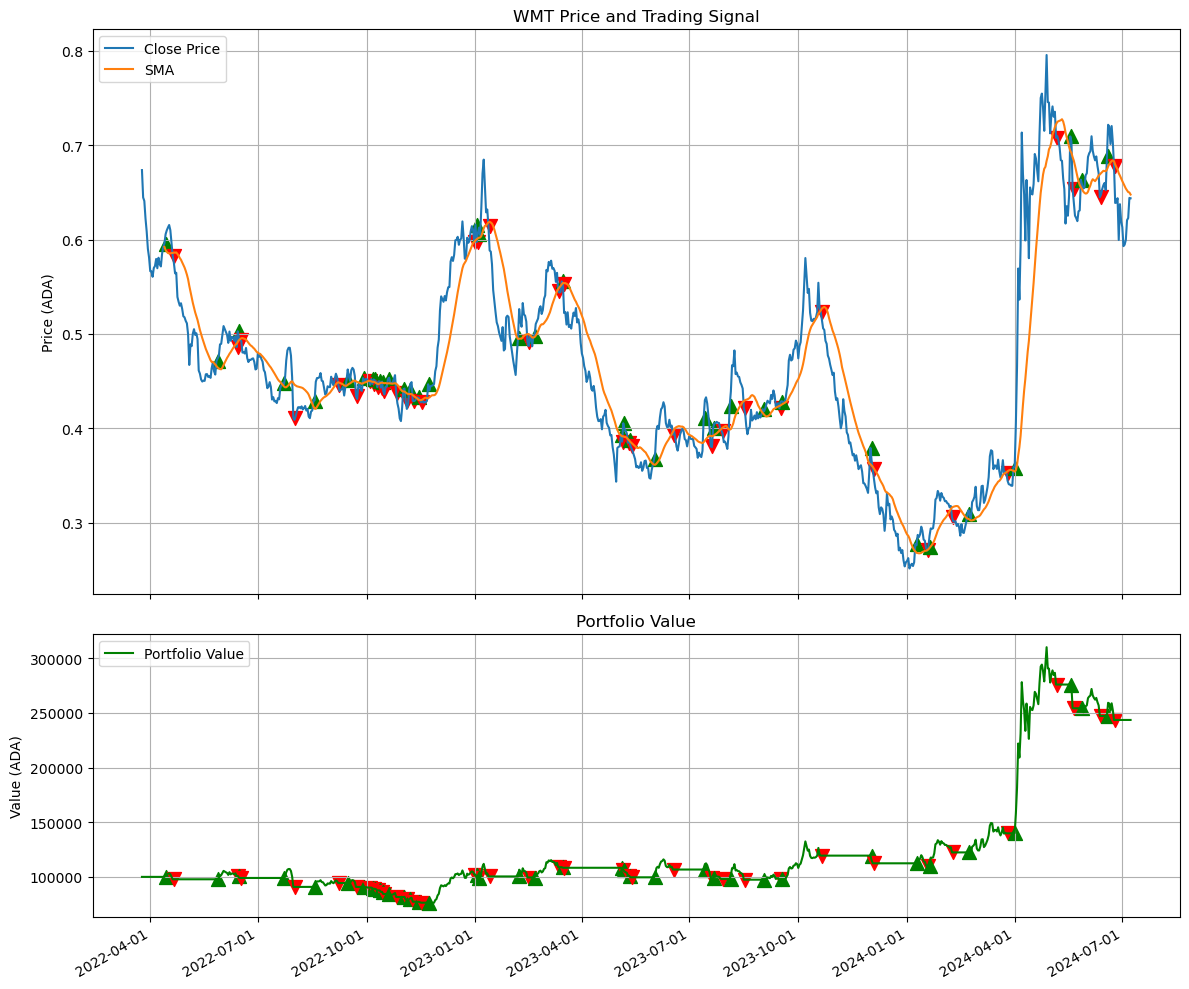


Trade Summary Table:
+------------+--------+----------+---------+-------------------+------------+
| Date       | Type   | Price    |    Size | Portfolio Value   |   Position |
+============+========+==========+=========+===================+============+
| 2022-04-14 | BUY    | 0.60 ADA |  167813 | 100000.00 ADA     |     167813 |
+------------+--------+----------+---------+-------------------+------------+
| 2022-04-21 | SELL   | 0.58 ADA | -167813 | 97801.65 ADA      |          0 |
+------------+--------+----------+---------+-------------------+------------+
| 2022-05-28 | BUY    | 0.47 ADA |  207514 | 97801.65 ADA      |     207514 |
+------------+--------+----------+---------+-------------------+------------+
| 2022-06-14 | SELL   | 0.49 ADA | -207514 | 100852.11 ADA     |          0 |
+------------+--------+----------+---------+-------------------+------------+
| 2022-06-15 | BUY    | 0.50 ADA |  200541 | 100852.11 ADA     |     200541 |
+------------+--------+----------+--------

In [4]:
def plot_results(data, strategy):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

    portfolio_values = strategy.portfolio_value
    
    if len(portfolio_values) < len(data):
        portfolio_values = [portfolio_values[0]] * (len(data) - len(portfolio_values)) + portfolio_values
    elif len(portfolio_values) > len(data):
        portfolio_values = portfolio_values[-len(data):]

    ax1.plot(data.index, data['close'], label='Close Price')
    
    sma_values = strategy.sma.array
    ax1.plot(data.index, sma_values, label='SMA')
    
    ax1.set_title('WMT Price and Trading Signal')
    ax1.set_ylabel('Price (ADA)')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(data.index, portfolio_values, label='Portfolio Value', color='green')
    ax2.set_title('Portfolio Value')
    ax2.set_ylabel('Value (ADA)')
    ax2.grid(True)
    ax2.legend()

    for trade in strategy.trade_log:
        if trade['type'] == 'BUY':
            ax1.scatter(trade['date'], trade['price'], marker='^', color='g', s=100)
            ax2.scatter(trade['date'], trade['portfolio_value'], marker='^', color='g', s=100)
        else:  # SELL
            ax1.scatter(trade['date'], trade['price'], marker='v', color='r', s=100)
            ax2.scatter(trade['date'], trade['portfolio_value'], marker='v', color='r', s=100)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

# Load data and run strategy (same as before)
data = pd.read_csv('WMT.csv', parse_dates=['date'], index_col='date')
cerebro = bt.Cerebro()
cerebro.adddata(bt.feeds.PandasData(dataname=data))
cerebro.addstrategy(SimpleStrategy)
initial_cash = 100000.0
cerebro.broker.setcash(initial_cash)
results = cerebro.run()
strategy = results[0]

# Plot results
plot_results(data=data, strategy=strategy)

# Print trade summary table and performance metrics (same as Stage 2)
print("\nTrade Summary Table:")
table_data = [
    [trade['date'], trade['type'], f"{trade['price']:.2f} ADA", trade['size'],
     f"{trade['portfolio_value']:.2f} ADA", trade['position']]
    for trade in strategy.trade_log
]
headers = ["Date", "Type", "Price", "Size", "Portfolio Value", "Position"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))

final_value = strategy.portfolio_value[-1] if strategy.portfolio_value else initial_cash
total_pnl = final_value - initial_cash
total_return = (final_value - initial_cash) / initial_cash

print(f'\nInitial Portfolio Value: {initial_cash:.2f} ADA')
print(f'Final Portfolio Value: {final_value:.2f} ADA')
print(f'Total Profit/Loss: {total_pnl:.2f} ADA')
print(f'Total Return: {total_return:.2%}')

This notebook provides a step-by-step demonstration of our WMT backtesting strategy, from basic execution to full visualization. Each stage builds upon the previous one, allowing for a clear understanding of how the different components contribute to the overall analysis.